Trial 10 Complete [00h 00m 08s]
val_loss: 0.08558796346187592

Best val_loss So Far: 0.03046410158276558
Total elapsed time: 00h 00m 46s
Best Hyperparameters:
{'units_1': 32, 'l2_1': 0.00017976711346215894, 'dropout_1': 0.4, 'units_2': 128, 'l2_2': 0.0001966340202965072, 'dropout_2': 0.4, 'learning_rate': 0.01}
Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Recall: 0.7807 - loss: 0.0975 - recall_class_0: 0.3080 - val_Recall: 0.9766 - val_loss: 0.0540 - val_recall_class_0: 0.0700
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - Recall: 0.9204 - loss: 0.0614 - recall_class_0: 0.1680 - val_Recall: 0.9961 - val_loss: 0.0430 - val_recall_class_0: 0.0950
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - Recall: 0.9483 - loss: 0.0576 - recall_class_0: 0.1327 - val_Recall: 0.9922 - val_loss: 0.0414 - val_recall_class_0: 0.1075
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - Recall: 0.9602 - loss: 0.0515 - recall_class_0: 0.1344 - val_Recall: 0.9922 - val_loss: 0.040

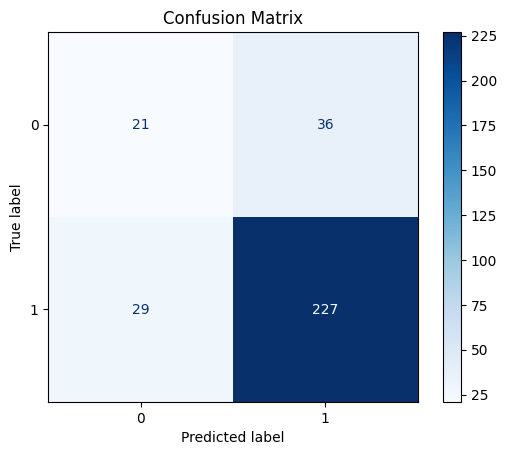

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.37      0.39        57
           1       0.86      0.89      0.87       256

    accuracy                           0.79       313
   macro avg       0.64      0.63      0.63       313
weighted avg       0.78      0.79      0.79       313



In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import tensorflow as tf
import keras_tuner as kt

def recall_class_0(y_true, y_pred):
    y_pred_class = K.cast(K.greater_equal(y_pred, 0.5), dtype='float32')
    y_true = K.cast(y_true, dtype='float32')  # Ensure both are float32
    true_positives = K.sum((1 - y_true) * (1 - y_pred_class))  # Class 0 TP
    actual_positives = K.sum(1 - y_true)  # Total Class 0
    return true_positives / (actual_positives + K.epsilon())

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        cross_entropy = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow((1 - p_t), gamma)
        return alpha_factor * modulating_factor * cross_entropy
    return loss

def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', min_value=32, max_value=256, step=32),
        activation='relu',
        input_dim=input_dim,
        kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_1', 1e-5, 1e-2, sampling='log'))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', min_value=32, max_value=128, step=32),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_2', 1e-5, 1e-2, sampling='log'))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss=focal_loss(alpha=0.8, gamma=2.5),
        metrics=['Recall', recall_class_0]
    )
    return model

path = "../data/processed/"
# Read the datasets from parquet format
X_train = pd.read_parquet(f"{path}X_train.parquet")
X_test = pd.read_parquet(f"{path}X_test.parquet")
y_train = pd.read_parquet(f"{path}y_train.parquet").squeeze()
y_test = pd.read_parquet(f"{path}y_test.parquet").squeeze()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Define input dimension
input_dim = X_train_scaled.shape[1]

# Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Search for best hyperparameters
tuner.search(
    X_train_balanced, y_train_balanced,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Retrieve best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hps.values)

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
loss, recall, recall_class_0_metric = best_model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss}")
print(f"Test Recall (Macro): {recall}")
print(f"Test Recall for Class 0: {recall_class_0_metric}")

# Predict and analyze results
threshold = 0.6  # Increase the threshold for classifying as class 1
y_pred = (best_model.predict(X_test_scaled) > threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Assuming binary classification
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix")
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [29]:
import sys
sys.path.append('/path/to/bias-fairness-mvp/src')

from training_utils import save_experiment_metadata

In [30]:
model_name = "NN"
parameters = ""
comments = ""

# Save experiment metadata
file_path = "../models/experiment_tracker.csv"
save_experiment_metadata(file_path, model_name, parameters, comments, y_test, y_pred)